In [ ]:
!pip install pybbn
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.dag import Edge,EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
pd.options.display.max_columns=50

  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40373 sha256=959751f4dea2f8c43a0ef340e627d918b679ef723f8bd894698399ddc2f6fd41
  Stored in directory: /root/.cache/pip/wheels/a7/6f/f1/ec7566a4882ab5c796fb43dfd84062769f75ba5381ca60d2b6
Successfully built pybbn


In [ ]:
df=pd.read_csv('weatherAUS.csv',encoding='utf-8')
df=df[pd.isnull(df['RainTomorrow'])==False]

<ipython-input-9-34e66bd4cf88>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df=df.fillna(df.mean())


              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.333792   
1       2008-12-02   Albury      7.4     25.1       0.0     5.333792   
2       2008-12-03   Albury     12.9     25.7       0.0     5.333792   
3       2008-12-04   Albury      9.2     28.0       0.0     5.333792   
4       2008-12-05   Albury     17.5     32.3       1.0     5.333792   
...            ...      ...      ...      ...       ...          ...   
129798  2017-05-17  Walpole     11.9     19.6       1.6     5.333792   
129799  2017-05-18  Walpole     11.6     22.1       0.0     5.333792   
129800  2017-05-19  Walpole     14.3     19.8      14.8     5.333792   
129801  2017-05-20  Walpole      8.6     14.7       7.4     5.333792   
129802  2017-05-21  Walpole     10.0     13.6       9.4     5.333792   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.557689           W           44.0          W        WNW 

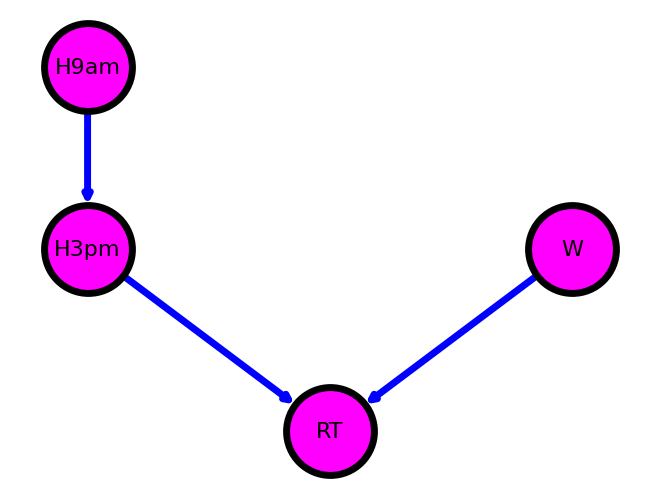

In [ ]:
df=df.fillna(df.mean())
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
print(df)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))
join_tree = InferenceController.apply(bbn)
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}
options = {
"font_size": 16,
"node_size": 4000,
"node_color": "magenta",
"edgecolors": "black",
"edge_color": "blue",
"linewidths": 5,
"width": 5,}
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()